In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [26]:
train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/augmented_train_data_224"
validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"
test_dir = "D:/retinal_data_set_visioncare/newTrainValidationTestData/new_test"

model_check_point_loc = 'D:/retinal_data_set_visioncare/models/vgg16/vgg16_dr.h5'

image_width = 224
image_height = 224
train_batchsize = 32
val_batchsize = 32

vgg_16_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [27]:
# Freeze the layers except the last 2 layers
for layer in vgg_16_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_16_model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000242EECED588> False
<keras.layers.convolutional.Conv2D object at 0x00000242DAA9B6A0> False
<keras.layers.convolutional.Conv2D object at 0x00000242EECEBA20> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242EECEBA58> False
<keras.layers.convolutional.Conv2D object at 0x00000242EECBB7B8> False
<keras.layers.convolutional.Conv2D object at 0x00000242EEC70D68> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242EECB20F0> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB35BB00> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB3F7DA0> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB3E2710> False
<keras.layers.pooling.MaxPooling2D object at 0x00000242DB415160> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB41FB38> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB428208> False
<keras.layers.convolutional.Conv2D object at 0x00000242DB43E710> False
<keras.

In [28]:
vgg_16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [29]:
#x = vgg_16_model_dup2.get_layer(index = -1).output
x = vgg_16_model.get_layer(index = -1).output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5, name='flatten_dropout')(x)
#x = BatchNormalization()(x)
#x = flatten(vgg_16_model_dup2.get_layer(index = -1).output)
#x = BatchNormalization()(x)
#x = Dropout(0.5, name='flatten_dropout')(x)
##################Additional Layer######################
x = Dense(64, use_bias=False, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5, name='fc1_dropout')(x)
################End Additional Layer####################
#x = Dense(5, use_bias=False, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(5, use_bias=False, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal(seed=None))(x)
#x = Dense(5, use_bias=False)(x)
x = BatchNormalization()(x)
predictions = Activation('softmax')(x)
#out_dup2 = new_classifier_layer(x)

model = Model(vgg_16_model.input, predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# # Change the batchsize according to your system RAM
# train_batchsize = 16
# val_batchsize = 10
# #train_dir = "D:/retinal_data_set_original/_1000_per_class_train/augmented_224/train"
# train_dir = "D:/retinal_data_set_original/original/new_train"
# #validation_dir = "D:/retinal_data_set_original/_1000_per_class_train/augmented_224/validation"
# validation_dir = "D:/retinal_data_set_original/original/new_valid"

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=train_batchsize,
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 5000 images belonging to 5 classes.
Found 281 images belonging to 5 classes.
Found 142 images belonging to 5 classes.


In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [32]:
model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [33]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=50,
      callbacks=[model_checkpoint],
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)
 
# Save the model
#model.save('D:/retinal_data_set_visioncare/models/vgg16/vgg16_dr_sgd.h5')

Epoch 1/50
78/78 [==============================] - 289s 4s/step - loss: 2.1508 - acc: 0.4085 - val_loss: 1.9773 - val_acc: 0.2109
Epoch 2/50
78/78 [==============================] - 274s 4s/step - loss: 1.5497 - acc: 0.5515 - val_loss: 2.0238 - val_acc: 0.2656
Epoch 3/50
78/78 [==============================] - 274s 4s/step - loss: 1.3396 - acc: 0.5949 - val_loss: 2.3243 - val_acc: 0.1406
Epoch 4/50
 7/78 [=>............................] - ETA: 3:59 - loss: 1.3426 - acc: 0.5424

KeyboardInterrupt: 

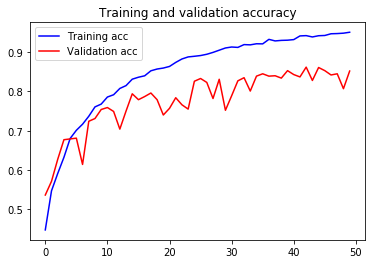

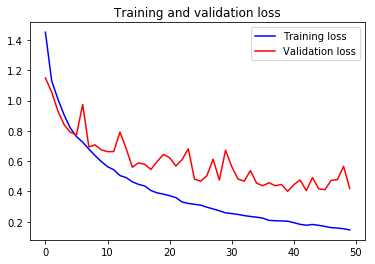

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()